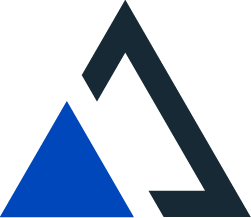

<h1><font color='#0047BB'>Semantic Inference: UDF Integration</font></h1>

Once you’ve installed AI-Link, here’s how you can connect programmatically to an AtScale data model. While use cases exist where importing from other portions of the package may be preferable, importing the following into your Python environment is generally a good starting point:

In [3]:
from atscale.client import Client
from atscale.project import Project
from atscale.data_model import DataModel
from atscale.eda import feature_engineering

To facilitate automated workflows, you can also import and instantiate `Project` and `DataModel` objects directly using the appropriate IDs.

<h3><font color='#0047BB'>Creating a Client</font></h3>

To connect with an AtScale data model, you need to create a `Client` object:

In [4]:
client = Client(
    server= ...,
    username= ...,
    password= ...,
    organization= ...
)

client.connect()

Here, we pass the following arguments to construct a Client object:
* The `server` argument is the URL of the AtScale server you’d like to connect to.
* The `username` argument is the AtScale username used to log in.
* The optional `password` argument is the password associated with the username above. If not specified in the constructor, you’ll be prompted to enter it when establishing a connection.
* The optional `organization` argument is the ID of the organization you wish to use. If not specified in the constructor, you’ll be prompted to select it from a list when establishing a connection.


<h3><font color='#0047BB'>Selecting a Project</font></h3>

After constructing a `Client` object, select a project:

In [5]:
project = client.select_project(draft_project_id = ...)

Please choose a published project:
Automatically selecting only option: "ID: 09681045-cb98-4251-6dce-fc6e649da2e1: Name: M5 Walmart Sales"


If the `draft_project_id` argument isn’t specified, you’ll be prompted to select from a menu of projects. Otherwise, the `draft_project_id` argument is the ID of the draft project you're connect to.

<h3><font color='#0047BB'>Selecting a Data Model</font></h3>

Finally, let’s select a data model:

In [7]:
data_model = project.select_data_model()

Please choose a data model:
Automatically selecting only option: "ID: f99aafe3-66ac-4df6-5096-1305cef92aa1: Name: m5_walmart_sales"


If the `data_model_id` argument isn’t specified, you’ll be prompted to select from a menu of data models. Otherwise, the `data_model_id` argument is the ID of the data model you’re trying to connect to.

The `DataModel` object allows you to interact with your AtScale data model by reading data, writing predictions, creating and engineering features, and more. 

<h3><font color='#0047BB'>Working with a UDF</font></h3>

In this case we are using a snowflake UDF which has been already defined called `predict_units_sold_test`. 


In [ ]:
# the name of our udf within snowflake
snowflake_udf_name = '"AI_LINK"."WALMART_M5_THIN".predict_units_sold_test'

We then need to provide it with metadata for the features to provide as input to the UDF, as well as information for the semantic model, including the feature names to join the QDS to the model with, and names for the newly created QDS and Measure.

In [19]:
# since this model is more complex, it takes in a number of inputs to make predictions
udf_inputs = ["date", "state",  "previous_weeks_units_sold"]

join_features = ["date", "state"]
new_feature_name = 'semantic_prediction'
qds_name = 'snowpark_prediction_qds'

Now we just need to construct the UDF query; this will be specific for each warehouse provider.

In [ ]:
# generate the parts of our udf query
feature_inputs = ", ".join(f'"{f}"' for f in udf_inputs)
snowflake_udf_call = f'{snowflake_udf_name}(array_construct({feature_inputs}))'
udf_database_query = data_model.get_database_query(feature_list = udf_inputs, use_aggs = False)

snowflake_udf_from_clause = f'({udf_database_query})'

Finally, we can tie the UDF to our semantic model using the `join_udf` function.

In [11]:
feature_engineering.join_udf(data_model=data_model,
                          target_columns=[f'{snowflake_udf_call} as "{new_feature_name}"'],
                          udf_call=snowflake_udf_from_clause,
                          join_features=join_features,
                          qds_name=qds_name)

As seen below, this new feature is now available in the semantic model.

In [17]:
data_model.get_data(feature_list=['date','state','total_units_sold','semantic_prediction_SUM'],
                            filter_between={
                                'date': ('04/16/2016','04/16/2016')})

date state  total_units_sold  semantic_prediction_SUM
0  2016-04-16    CA             20564                    23311
1  2016-04-16    TX             12460                    13360
2  2016-04-16    WI             15338                    19669